In [1]:
from utils import create_or_load_pickle, ignore_warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
ignore_warnings()

これまでは訓練データを数値ベクトル化することが簡単であったが，音楽はそうはいかない．  
ここでは音楽ジャンル分類問題を扱う．  
音楽データをその特性をとらえることができる数値に変換するにはどうすればいいか，見ていく．

# まとめ
音楽の複数ジャンル分類問題
- GTZANというデータセットを利用
    - 10個のジャンルのうち6個を今回は使用
- FFTによる分類: あまりうまくいかない
    - FFT, 高速フーリエ変換: 波形データを周波数の違うサイン波に分解し，周波数ごとの強度を可視化する
        - バタフライ演算による対数オーダーの高速化
    - ロジスティック回帰によるジャンル分類
        - 多値分類問題にも適用できるが，2値分類問題として学習させた方がよさげ
    - 混同行列: どのジャンルが正解のとき，どのジャンルに何曲分類されたかを可視化できる．対各成分が濃いと良い．
        - matplotlibのmatshow関数で可視化できる
    - ROC(receiver operator characteristic)曲線による評価
        - false positive rateとtrue positive rateによる曲線，こちらもP/R曲線と同様，AUCが高いほど良い
        - P/R曲線は陽性サンプルが貴重なとき有効なのに対し，ROCは分類器の振る舞いについて全体像を見たいときに利用する．
- メル周波数ケプストラム係数(MFCC)による分類: 割とうまくいく
    - MFCC
        - 音声の波形データを低次元に落とし込む「手法」
        - 波形→離散フーリエ変換→対数を取る→メルフィルタバンクをかける→離散コサイン変換→低次の係数を取得
        - libsoraパッケージで波形からMFCCを得る関数を利用可能
    - ROC曲線のAUC,混同行列の対角線の濃さ共に全体的に良好だが，カントリーやジャズの分類は難しい模様

# 本章のロードマップ
音楽(MP3ファイルを想定)のジャンル分類問題では，以下のようなことが問題になってくる．
- サウンドベースの特徴量の取得
- 多クラスへの分類
- 分類期のパフォーマンス評価の手法

# 音楽データを取得する
GTZANというデータセットを使用する．  
URLは http://opihi.cs.uvic.ca/sound/genres.tar.gz  
10個のジャンルが存在するが，ここでは「クラシック，ジャズ，カントリー，ポップ，ロック，メタル」を用いることにする．  
各ジャンルごとに100曲のデータが存在し，それぞれ最初の30秒だけから構成される．

## WAVフォーマットに変換する
ジャンル分類に利用するならば，MP3よりもWAVで扱う方が都合が良いので変換しておく．  
ファイルの変換には[AV Audio Converter](https://www.audio4fun.com/player/audio-converter.htm)が便利だが，音波生成などの便利機能をコマンドライン上で利用できる[sox](https://sourceforge.net/projects/sox/files/sox/14.4.2/)も使える．  
soxは，環境変数を通すことで使用できるようになる．  
ここではサンプリングレート22050Hz，モノラルでWAVファイルに変換する．（そうしないとデータが二次元になって面倒）  
wavはscipyによって読み込むことができる．

In [2]:
from scipy.io import wavfile 

In [4]:
wave_filename = "./data/ch09/sample.wav"
sample_rate, X = wavfile.read(wave_filename)

# 音楽を見る
音楽のスペクトログラムを描画する．  
スペクトログラムは，音楽の周波数を視覚化するための画像表現．  
横軸は時間，縦軸は周波数，色の濃さはその時間，その周波数の信号強度を示す．  
matplotlibのspecgram()という関数を利用する．  

22050 (941184,)


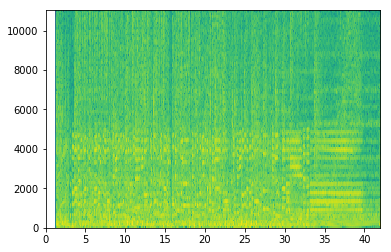

In [7]:
print(sample_rate, X.shape)
spec = plt.specgram(X, Fs=sample_rate, xextent=(0, len(X) // sample_rate))

このようにしてスペクトログラムを表示すると，例えばメタルは全体的に濃く，ジャズは薄いといったパターンが見て取れる．  
メタルとジャズの分類は簡単にできそうだが，ロックとカントリー音楽のペアなどは難しい．

## 音楽をサイン波に分解する
周波数ごとの強度を分類器に入力する特徴量としてみたい．  
そのために，高速フーリエ変換(FFT)を行う．簡単な仕組みについては[この記事](https://www.yukisako.xyz/entry/fourier-transform)  
FFTの理論はここでは述べず，どのようなことができるのかを説明．  

例として，2つのサイン波のフーリエ変換について見てみる．  
まずは周波数の違う2つのサイン波をsoxで作成

``` bash
> sox --null -r 22050 sine_a.wav synth 0.2 sine 400  
> sox --null -r 22050 sine_b.wav synth 0.2 sine 3000
```
400Hzの波を3000Hzの波の半分のボリュームにし，2つを混ぜ合わせる．  
``` bash
> sox --combine mix --volume 1 sine_b.wav --volume 0.5 sine_a.wav sine_mix.wav
```
それぞれの波形とフーリエ変換後のスペクトルを見てみる．  
なお，フーリエ変換はScipyで行うが，numpy.fft.fft()で行うこともできる．詳しくはhttps://momonoki2017.blogspot.com/2018/03/pythonfft-1-fft.html

In [3]:
import scipy as sp

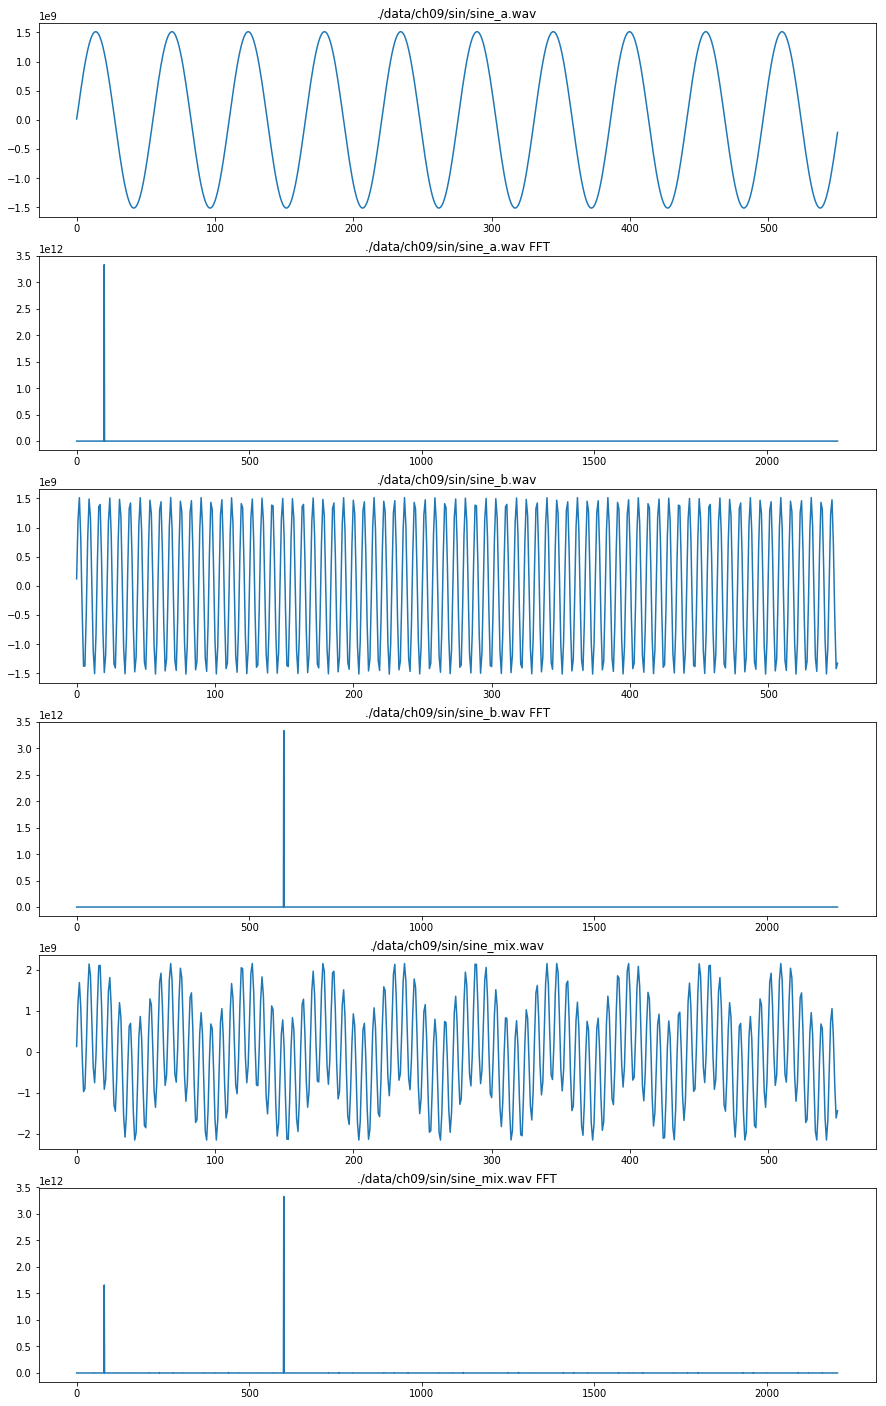

In [35]:
sin_a_path = "./data/ch09/sin/sine_a.wav"
sin_b_path = "./data/ch09/sin/sine_b.wav"
sin_mix_path = "./data/ch09/sin/sine_mix.wav"

paths = [sin_a_path, sin_b_path, sin_mix_path]
waves = [ wavfile.read(path)[1] for path in paths ]
ffts = [ abs(sp.fft(wave)) for wave in waves ] # numpy によるFFT

fig, axs = plt.subplots(nrows=6, figsize=(15, 25))

for i in range(len(waves)):
    axs[2*i].plot(range(len(waves[i]) // 8), waves[i][:len(waves[i]) // 8]) # 波が見えなくなるので途中まで
    axs[2*i].set_title(paths[i])
    
    axs[2*i+1].plot(range(len(ffts[i]) // 2), ffts[i][:len(ffts[i]) // 2]) # 鏡像が出現してしまうので半分まで
    axs[2*i+1].set_title(paths[i] + " FFT")

実際の音楽データをフーリエ変換してみると，もっと複雑になる．

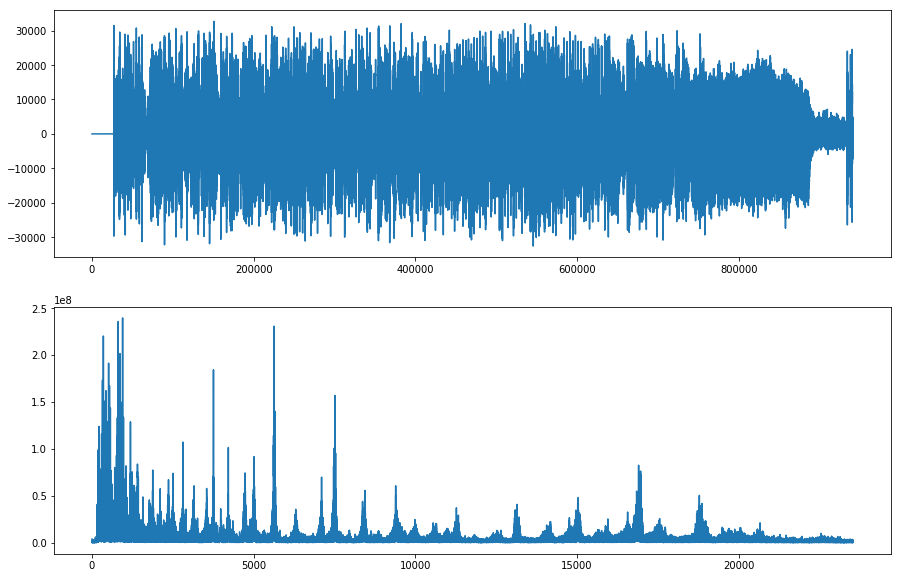

In [36]:
wave_filename = "./data/ch09/sample.wav"
sample_rate, wave = wavfile.read(wave_filename)
fft = abs(sp.fft(wave))

fig, (ax_wave, ax_fft) = plt.subplots(nrows=2, figsize=(15, 10))
ax_wave.plot(range(len(wave)), wave)
ax_fft.plot(np.arange(len(fft) // 4) / 10, fft[:len(fft) // 4]) # 0.1Hzごとの出力？

# FFTを用いて最初の分類器を作成する
FFTを用いて音楽を識別できる「指紋」のようなものを作る．  
FFTをデータ，対応するジャンルをラベルとして設定し，分類器に入力することを目指す．

## 機敏に実験する
実験のたびにFFTしていては時間がかかるので，キャッシュデータを作っておく．  
また，FFTの結果周波数のほとんどは1000Hz以下であることが分かるので，ひとまず特徴量としてはその範囲のみで十分とする．

In [4]:
import os, glob

SAVE_DIR = "./data/ch09/fft/"
GENRE_LIST = ["classical", "jazz", "country", "pop", "rock", "metal"]

def create_fft(file_path, save_dir=SAVE_DIR, subdir=None):
    sample_rate, wave = wavfile.read(file_path)
    fft = abs(sp.fft(wave)[:1000])
    file_name = os.path.split(file_path)[-1]
    
    data_name, extension = os.path.splitext(file_name) # 拡張子を取り除く
    if subdir != None:
        data_name = os.path.join(subdir, data_name)
    data_name = data_name + ".fft"
    data_path = os.path.join(save_dir, data_name)

    np.save(data_path, fft)
    return data_path

def read_fft(save_dir=SAVE_DIR, genre_list=GENRE_LIST):
    X = []
    y = []
    for label, genre in enumerate(genre_list):
        genre_path = os.path.join(save_dir, genre, "*.fft.npy")
        files = glob.glob(genre_path)
        for file in files:
            fft = np.load(file)
            X.append(fft[:1000])
            y.append(label)
    return np.array(X), np.array(y)

In [ ]:
create_fft("./data/ch09/sample.wav", subdir="classical")

In [ ]:
for genre in GENRE_LIST:
    files = glob.glob(os.path.join("./data/ch09/genres", genre, "*.wav"))
    for file in files:
        fft_file = create_fft(file, subdir=genre)
        # print(f"FFT file of {file} is created as {fft_file}.npy")

In [5]:
X, y = read_fft()
print(X.shape)
print(y.shape)

(600, 1000)
(600,)


## 分類器の訓練を行う
ここでは6クラスへのロジスティック回帰を行う．  
この場合，2クラス分類に比べて問題が難しくなるので，正解率50%はとてもよく，ランダムに予測した場合の期待正解率は16.7%になる．  
突然次の節からもう多クラス分類ができてる前提で話が進んでいるので，ここで分類をやっておく．

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

def train_by_logistic_regression(train_data, train_label, split=4):
    clf = LogisticRegression()
    clf.fit(train_data, train_label)
    return clf

In [7]:
# 学習
train, test = list(KFold(n_splits=4, shuffle=True, random_state=0).split(X))[0]
clf = create_or_load_pickle("./data/ch09/logistic_model.pkl", lambda : train_by_logistic_regression(X[train], y[train]))

# 予測
y_pred = clf.predict(X[test])
y_test = y[test]

./data/ch09/logistic_model.pkl was loaded from the pickle file.


後ほど平均と正規化を行うため，誤った分類は0，正しい分類は1というように正規化しておく．

In [8]:
def normalize_prediction(pred, label):
    if len(pred) != len(label):
        raise ValueError("Lengths of prediction and label must be same.")
    return [1 if pred[i] == label[i] else 0 for i in range(len(label))]

In [9]:
y_norm = normalize_prediction(y_test, y_pred)
print(len(y_norm))
print(sum(y_norm))

150
55


## 混同行列を用いて多クラス問題の正解率を計測する  
多クラス分類の場合，どれだけ正しく分類できたかということだけでなく，どのジャンルで誤分類が多いかを見たい．  
これを行うためには，混合行列というものを用いる．

In [10]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[18  2  1  3  2  1]
 [ 5  8  4  0  1  0]
 [ 1  7  4  3  9  1]
 [ 1  5  3  5  8  3]
 [ 2  5  5  2 12  3]
 [ 1  2  3  1 11  8]]


例えば1行目について見てみる．  
元々クラシックだった曲がクラシックに分類されている数は18，間違えてジャズと分類した曲が3曲,,,となっていることを意味する．  

さらに混合行列をmatshowによって可視化する．

In [11]:
from matplotlib import pylab

def normalize_confusion_matrix(cm):
    return (cm.T / np.sum(cm, axis=1)).T

def plot_confusion_matrix(cm, genre_list=GENRE_LIST, vmin=0, vmax=1.0):
    cm = normalize_confusion_matrix(cm)
    
    pylab.clf()
    pylab.matshow(cm, fignum=False, cmap="Blues")
    
    ax = pylab.axes()
    ax.set_xticks(range(len(genre_list)))
    ax.set_xticklabels(genre_list)
    ax.xaxis.set_ticks_position("bottom")
    ax.set_yticks(range(len(genre_list)))
    ax.set_yticklabels(genre_list)
    
    pylab.title("Confusion Matrix")
    pylab.colorbar()
    pylab.grid(False)
    pylab.xlabel("Predicted class")
    pylab.ylabel("True class")
    pylab.show()

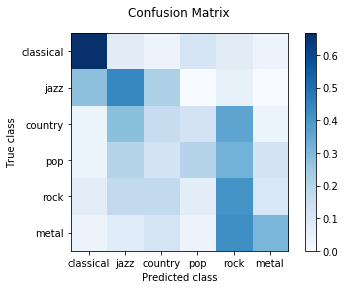

In [12]:
plot_confusion_matrix(cm)

完璧な分類器ほど対各成分だけが濃く描画されることになるが，この結果はクラシック以外そうでもない．  
パラメータチューニングでよりよくなる可能性もあるが，ここからは既存研究について見ていく．

## ROC曲線によるクラス分類器の評価方法
正解率を計測するだけではなく，適合率-再現率曲線(P/R曲線)やその兄弟分のROC曲線(reveiver operator characteristic)で評価を行う．  
P/R曲線は陽性クラスに興味があったり，陽性のサンプル数が少ない，「情報検索」や「不正行為検出」などに利用する．  
ROC曲線は分類器の振る舞いについて全体像を見たいときに利用する．  
カントリー音楽をどれだけ正しく分類できるかを見てみる．

In [13]:
from sklearn.metrics import precision_recall_curve, auc

def plot_pr_curve(test, pred):
    precisions, recalls, pr_thresholds = precision_recall_curve(test, pred)
    
    plt.plot(recalls, precisions)
    plt.fill_between(recalls, precisions, facecolor='blue', alpha=0.5)
    plt.grid()
    plt.xlabel("recall")
    plt.ylabel("precisions")
    plt.title("precision-recall curve (AUC = %.3f)" % auc(recalls, precisions))

# PR曲線を描くには2値分類にする必要がある．
def binarize(data, target_label):
    return np.asarray(data == target_label, dtype=int)

In [14]:
train, test = list(KFold(n_splits=4, shuffle=True, random_state=0).split(X))[0]

target_id = GENRE_LIST.index("country")
y_country = binarize(y, target_id)

func = lambda : train_by_logistic_regression(X[train], y_country[train])
clf = create_or_load_pickle("./data/ch09/logistic_model_country.pkl", func, create_new=False)

pred_country = clf.predict_proba(X[test])[:, 1] # 0: ハズレの確率，1: 正解の確率
test_country = y_country[test]

./data/ch09/logistic_model_country.pkl was loaded from the pickle file.


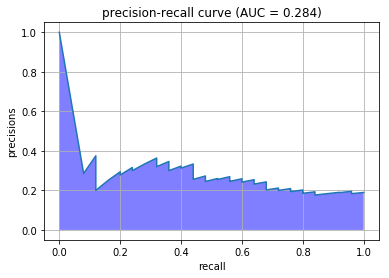

In [15]:
plot_pr_curve(test_country, pred_country)

ROC曲線はfalse positiveの比率とtrue positiveの比率をプロットしたもの．  
理想的な分類器は左下から右上に掛けてAURの大きな弧を描き，ランダムに予測した場合は直線になって，AUCは0.5になる．  
PR曲線のAUCが大きい分類器は，ROC曲線のAUCも大きいことがJesseらの研究(ICML 20006)などで知られている．  
両曲線のx軸とy軸の定義は以下．FPとかTPとかの覚え方は，「合ってるか|事実はどうか」  

|事実|分類器の予測|結果|
|:-:|:-:|:--|
|陽|陽|True positive(TP)|
|陽|陰|False positive(FP)|
|陰|陽|False negative(TN)|
|陰|陰|True negative(FN)|

|曲線|x軸|y軸|
|:--|:--:|:--:|
|P/R|Recall=$\frac{TP}{TP+FN}$|Precision=$\frac{TP}{TP + FP}$|
|ROC|FPR=$\frac{FP}{FP + TN}$|TPR=$\frac{TP}{TP + FN}$|

FPRは陰性である例に対して誤って陽性と判断した割合．0に近いほど良い．  
TPRは陽性である例に対して正しく陽性と判断した割合．1に近いほど良い．  
<br>
ROC曲線を描く関数を作ってみる．

In [16]:
from sklearn.metrics import roc_curve

def plot_roc_curve(test, pred):
    fpr, tpr, roc_thresholds = roc_curve(test, pred)
    
    plt.plot(fpr, tpr)
    plt.fill_between(fpr, tpr, facecolor='blue', alpha=0.5)
    plt.plot(np.linspace(0, 1, len(fpr)), np.linspace(0, 1, len(tpr)), linestyle="dotted", color="black", linewidth=3)
    plt.grid()
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.title("ROC curve (AUC = %.3f)" % auc(fpr, tpr))

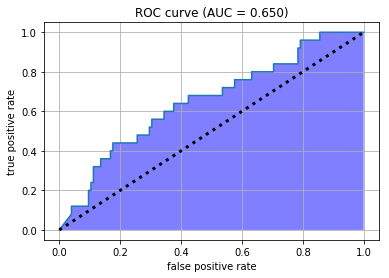

In [57]:
plot_roc_curve(test_country, pred_country)

全てのジャンルについてROC曲線を描いてみる．

In [17]:
def plot_all_roc_curve(X, y, genre_list=GENRE_LIST, test_rate=0.25):
    train, test = list(KFold(n_splits=int(1 / test_rate), shuffle=True, random_state=0).split(X))[0]

    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 15))

    for i in range(len(genre_list)):
        y_genre = binarize(y, i)
        clf = train_by_logistic_regression(X[train], y_genre[train])
        pred_genre = clf.predict_proba(X[test])[:, 1] # 0: ハズレの確率，1: 正解の確率
        test_genre = y_genre[test]

        fpr, tpr, roc_thresholds = roc_curve(test_genre, pred_genre)

        axs[i%3][i%2].plot(fpr, tpr)
        axs[i%3][i%2].fill_between(fpr, tpr, facecolor='blue', alpha=0.5)
        axs[i%3][i%2].plot(np.linspace(0, 1, len(fpr)), np.linspace(0, 1, len(tpr)), linestyle="dotted", color="black", linewidth=3)
        axs[i%3][i%2].grid()
        axs[i%3][i%2].set_xlabel("false positive rate")
        axs[i%3][i%2].set_ylabel("true positive rate")
        axs[i%3][i%2].set_title(f"ROC curve of {GENRE_LIST[i]} (AUC = %.3f)" % auc(fpr, tpr))

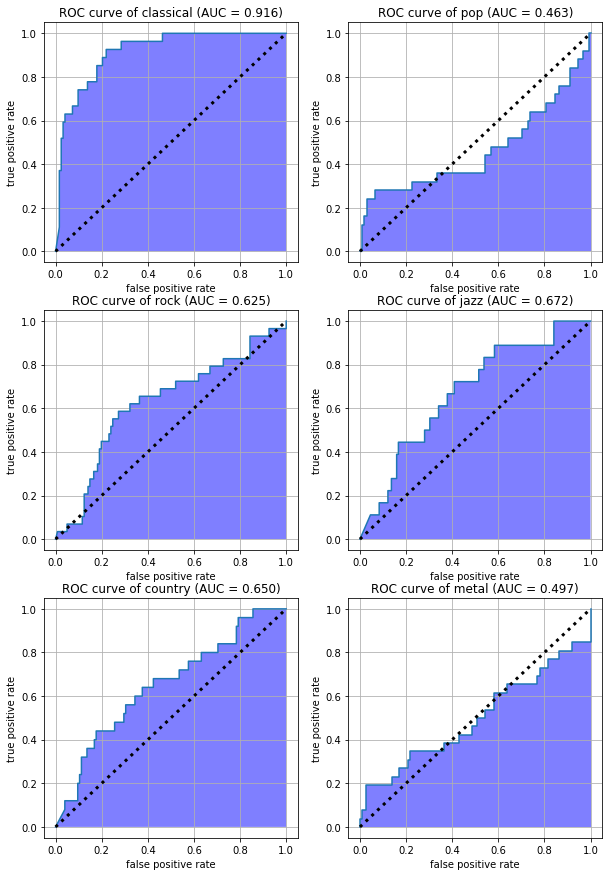

In [17]:
plot_all_roc_curve(X, y)

クラシック以外はあまり役に立たないことが分かる．

# メル周波数ケプストラム係数を用いて分類器を改良する
他の方法も見てみよう．  
音楽ジャンル分類のカンファレンスとして，ISMIR(International Society for Music Information Retrieval)が毎年開かれている．  
AMGC(Automatic Music Genre Classification)は音楽情報検索(Music Information Retrieval: MIR)で確立された分野の一つである．  
その研究成果の中でも，ここではメル周波数ケプストラム係数(Mel Frequency Cepstral Coefficient: MFCC)という手法を利用してみる．  
メル周波数ケプストラム(Mel Frequency Cepstrum: MFC)は音のパワースペクトラムをエンコードしたものである．  
対象とする信号のパワースペクトラムの対数をフーリエ変換することで計算できる．  
MFCは音声認識や話者認識で利用されていて，その有効性が実証されている．  
MFC係数の計算にはパッケージを利用する．本ではscikitを紹介しているが，pipでインストールができないので代わりにlibrosaを利用する．
https://qiita.com/martin-d28jp-love/items/34161f2facb80edd999f
``` bash
> pip install librosa
```

## メル周波数ケプストラムについて
音声としての情報をできるだけ損なわずに現実的な次元にまで落とす手法の一つ．  

### メル(尺度)周波数
人間の音高知覚的尺度．  
ある音のメル周波数の二倍の音は人間にとって二倍の高さに聞こえる．半分もまた然り．  
周波数領域でのオクターブとは異なるので注意．  
$$ m = m_0 \ln( \frac{f}{f_0} + 1 ) $$
なお，$1000mel = 1000Hz$という制約が基準となり，以下が成り立つようにする．
$$ m_0 = \frac{1000}{\ln{\frac{1000}{f_0} + 1}} $$

### ケプストラム
元の波形を「フーリエ変換→log→逆フーリエ変換」という手順で得られるデータ  
スペクトルの細かな変動と大まかな包絡に分けることができる．  
大まかな訪ロの方は人間の声道の特性を表しているので，音声認識や音声合成で重要．  
http://aidiary.hatenablog.com/entry/20120211/1328964624  

### 変換手順
1. 音声データをフレーム分割する
    - ハミング窓などで短い時間ごとに分割する
2. 離散フーリエ変換でフレームごとの周波数スペクトルを得る
3. 周波数スペクトルの対数をとる
4. メルフィルタバンクによって各周波数スペクトルをメル周波数領域で均等にする
    - 上限周波数～下限周波数までをいくつかのサブバンドに分け，メルフィルタバンクのフィルタ式を通した結果の和をサブバンドごとに取る
5. それぞれのフレームに離散コサイン変換をかけ，フレームごとの係数を得る．
    - DFTは虚部が無く計算が楽
    - DFTの特徴として低次元の方に情報が集中するため，低次項から適当な数の係数を取ってくれば良い．

In [18]:
from librosa.feature import mfcc

In [23]:
sr, X = wavfile.read("./data/ch09/sample.wav")
mfccs = mfcc(np.array(X, dtype=float), sr=sr) # floatのnparrayである必要がある
print(mfccs.shape)

(20, 1839)


全部で1839フレームあり，それぞれのフレームに20個の係数が入っている．  
20個の係数をフレームで平均した値を新たな特徴量として扱う．  
<br>
さらに，曲の最初と最後は曲の中間部分と比べてあまりジャンルに関係ないメロディであると想定して，最初と最後の10%を無視する．  

In [24]:
ceps = mfccs.T
n_ceps = len(ceps)
feature_x = np.mean(ceps[n_ceps // 10 : (n_ceps * 9) // 10], axis=0)
print(feature_x.shape)

(20,)


MFCC特徴量をキャッシュデータとして保存しておく．

In [19]:
SAVE_DIR = "./data/ch09/ceps/"

def create_ceps(file_path, save_dir=SAVE_DIR, subdir=None):
    sample_rate, wave = wavfile.read(file_path)
    ceps = mfcc(np.array(wave, dtype=float), sr=sample_rate).T
    
    file_name = os.path.split(file_path)[-1]
    data_name, extension = os.path.splitext(file_name) # 拡張子を取り除く
    if subdir != None:
        data_name = os.path.join(subdir, data_name)
    data_name = data_name + ".ceps"
    data_path = os.path.join(save_dir, data_name)

    np.save(data_path, ceps)
    return data_path

def read_ceps(save_dir=SAVE_DIR, genre_list=GENRE_LIST, feature_length=1000):
    X = []
    y = []
    for label, genre in enumerate(genre_list):
        genre_path = os.path.join(save_dir, genre, "*.ceps.npy")
        files = glob.glob(genre_path)
        for file in files:
            ceps = np.load(file)
            n_ceps = len(ceps)
            feature_x = np.mean(ceps[n_ceps // 10 : (n_ceps * 9) // 10], axis=0)
            
            X.append(feature_x[:feature_length])
            y.append(label)

    return np.array(X), np.array(y)

In [ ]:
for genre in GENRE_LIST:
    files = glob.glob(os.path.join("./data/ch09/genres", genre, "*.wav"))
    for file in files:
        ceps_file = create_ceps(file, subdir=genre)
        # print(f"CEPS file of {file} is created as {ceps_file},npy")

In [20]:
X, y = read_ceps()

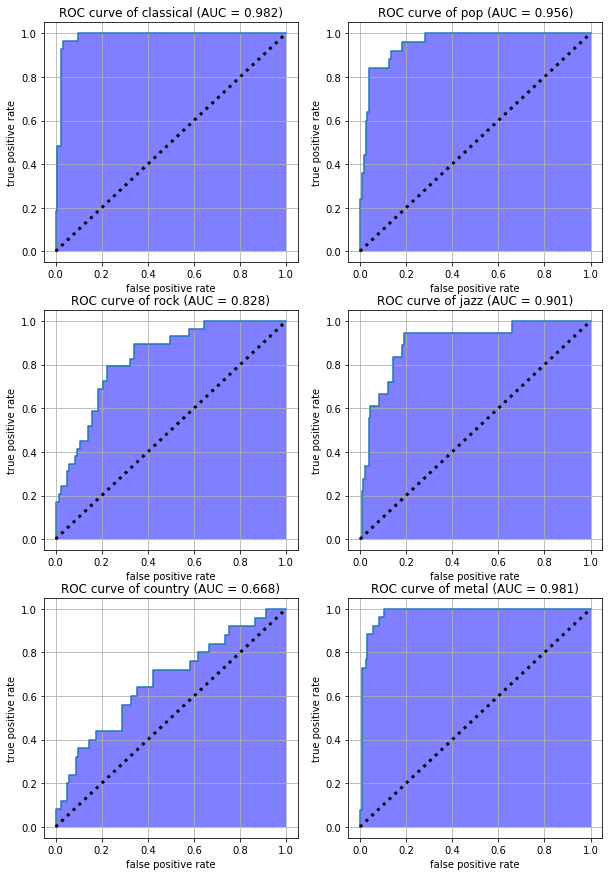

In [26]:
plot_all_roc_curve(X, y)

つよい！  
が，Countryは難しいみたい．  
<br>
混同行列を見てみる

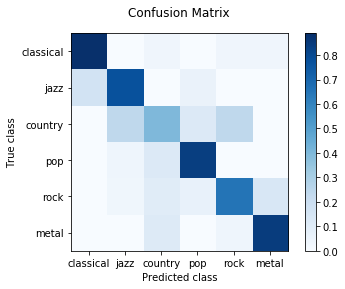

In [21]:
train, test = list(KFold(n_splits=4, shuffle=True, random_state=0).split(X))[0]
clf = train_by_logistic_regression(X[train], y[train])
y_pred = clf.predict(X[test])
y_test = y[test]

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

割と見事な対角線，ただしcountry以外  
さらに改良したいのであれば，混合行列でうまくいっていないところに注力すればいい．例えば，countryはjazzと間違えやすい．  
<br>
ISMIRでは，AFTE(Auditory Filterbank Temporal Envelope)と呼ばれる特徴量を扱った論文もあり，こちらはMFCCを上回る性能があるらしい．  
今回は，特徴量抽出の仕組みをブラックボックス化していたが，このように結果を得ることはできることが分かる．